# Principal Component Analysis

Here comes the next fitting technique. Wooo!!!!! So, principal component analysis (PCA) seems like it will be the most promising fitting method, as evidenced in the paper (de Oliveira-Costa et al. 2008). It is an efficient way to compress data as we are able to fit the data with as few parameters as possible while maintaining accuracy. When there are too many parameters, it leads to the risk of overfitting. 

Summary of steps for PCA:
<ol>
<li>Standardize the data (to ensure the data is at the same scale)</li>
<li>Find the covariance matrix </li>
<li>Compute eigenvalues and eigenvectors </li>
<li>Rank eigenvectors </li>
</ol>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib notebook 

In [2]:
data = np.load('500pixels.npz')
data_matrix = data['arr_0'] #matrix of intensity 500x30

In [3]:
# data = pd.read_csv('avg_intensities.txt',sep = "\s+", names = ['Frequency (GHz)','Intensity'],skiprows = [0,1])
# xval = data['Frequency (GHz)'].values
# yval = data['Intensity'].values
# data_matrix = yval.reshape(9,30) #matrix of intensity 30x30
# np.hstack([xval[:30].reshape(30,1),yval[:30].reshape(30,1)]) #matrix of frequency and intensity (30x2)

## Standardization and Finding Covariance

To begin, we need to calculate the covariance matrix. The covariance matrix should be the same dimensions as the dimensions for data which, in this case, is 2 dimensions. There are different ways to calculate the covariance matrix but essentially it requires normalizing the data set by subtracting off the mean. The steps used here to calculate the covariance matrix is as follows:
<br>
###  Standardize data set
To standardize it, I just subtracted the mean value from the data set to make sure the data is the same scale. 
    Let $X$ be the matrix of the data of $nxp$ dimensions such that $X = \begin{bmatrix}
            x_{11} & \ldots & x_{1p} \\
            \vdots &  & \vdots \\
            x_{n1} & \ldots & x_{np}\\
            \end{bmatrix} $
    <ol>
      <li>Found the mean of each column of the matrix then put it in a vector. Let j = 1,..,p. 
                 $$u_{j} = \frac{1}{n} \sum_{i=1}^{n}{X_{ij}} \quad where \quad \bar{u} = \begin{bmatrix}
                                                                                u_{1} \\
                                                                                \vdots \\
                                                                                u_{p} \\
                                                                                \end{bmatrix}$$</li>
            <li>Multiplied a vector of ones (h vector of $nx1$ size) and the transpose mean vector ($1xp$) to create a $nxp$ matrix of the mean values.</li>
                 $$\bar{h}\bar{u}^{T}$$
            <li>Subtracted mean matrix ($nxp$) from the $nxp$ matrix of data set to form B matrix ($nxp$).</li>
                  $$B = X - \bar{h}\bar{u}^{T}$$
</ol>

### Find the covariance matrix
 With the standardized matrix found (B matrix), the covariance matrix of $pxp$ size can be calculated with
    $$C = \frac{1}{n-1} B^{T}B$$

Credit: I based this off the wiki page for PCA (https://en.wikipedia.org/wiki/Principal_component_analysis#Derivation_of_PCA_using_the_covariance_method)

In [4]:
#args matrix of data
#returns covariance of data and normalized data set
def cov_matrix(x_matrix):
    column_vec = data_matrix[:,np.arange(x_matrix.shape[1])] #taking each column vector of matrix
    mean_vector = np.c_[np.mean(column_vec,axis=0)] #calculating mean for each column and adding to vector
    ones_vector = np.ones([x_matrix.shape[0],1]) #one vector 
#     print('Mean value ', np.dot(ones_vector,mean_vector.T), 'and mean vector \n', mean_vector)
    b_matrix = x_matrix - np.dot(ones_vector,mean_vector.T) #subtracting mean value 
    cov = (np.dot(b_matrix.T,b_matrix))/(x_matrix.shape[0]-1) #covariance matrix formula
    return cov,b_matrix 

## Eigenvalues and Eigenvectors

With the covariance matrix, we can find eigenvectors $\bar{v}$ such that $C\bar{v}=\lambda \bar{v}$ for eigenvalue $\lambda$. For a $pxp$ covariance matrix there will be $p$ eigenvectors with a corresponding set of eigenvalues. To determine how much information or variance is attributed to each principal component, you can calculate the explained variance. You determine the sum of all the eigenvalues and divide each eigenvalue by that sum. The result is a percentage of the total variance that is explained by each eigenvalue.

With the explained variance, we can rank the eigenvectors by the eigenvalue with their corresponding eigenvectors from highest to lowest to determine an order of significane. 

In [59]:
cov,stand_matrix = cov_matrix(data_matrix)
eigval,eigvec = np.linalg.eig(cov) #finding eigenvalues and eigenvectors
eig_pairs = [(eigval[i],eigvec[:,i]) for i in range(eigvec.shape[1])] #creating a tuple of eigval and eigvec
eig_pairs.sort() #sorting from least to greatest
eig_pairs.reverse() #reversing order to greatest to least

In [77]:
total_eig = np.sum(eigval)
var_exp = np.sort([(eigval[i]/total_eig) for i in np.arange(eigval.size)]) #calculating and sorting explained variance
var_exp = var_exp[::-1] #reverse array to descending order
eigval_dict = dict(zip(np.arange(1,var_exp.size+1),var_exp)) #adding ordered eigvalues to dictionary with rank as key
print(eigval_dict)

{1: 0.9999999966424206, 2: 3.323195753083009e-09, 3: 3.2547813615351494e-11, 4: 1.2164335521075998e-12, 5: 5.910466243072827e-13, 6: 2.6789276830117494e-14, 7: 1.3503881546509144e-15, 8: 3.1779065781195067e-16, 9: 5.535960312485228e-18, 10: 4.513458003931479e-20, 11: 6.338039244720559e-21, 12: 9.621202301272706e-22, 13: 6.468067001988365e-22, 14: 5.933233359449296e-22, 15: 4.452775741843817e-22, 16: 5.785515839504507e-23, 17: 2.1250855216855872e-23, 18: 1.932471596841768e-23, 19: 6.333931901642525e-24, 20: 3.2302097097089315e-24, 21: 1.4893456745570116e-24, 22: 8.037464305446067e-25, 23: 5.0682235576265e-25, 24: 3.1539687938489587e-25, 25: 1.3513195771484543e-25, 26: 8.214547590306695e-26, 27: 3.434747379192848e-26, 28: 1.1929441774224943e-26, 29: 3.693885564293162e-27, 30: 1.2858102173350038e-27}


<IPython.core.display.Javascript object>


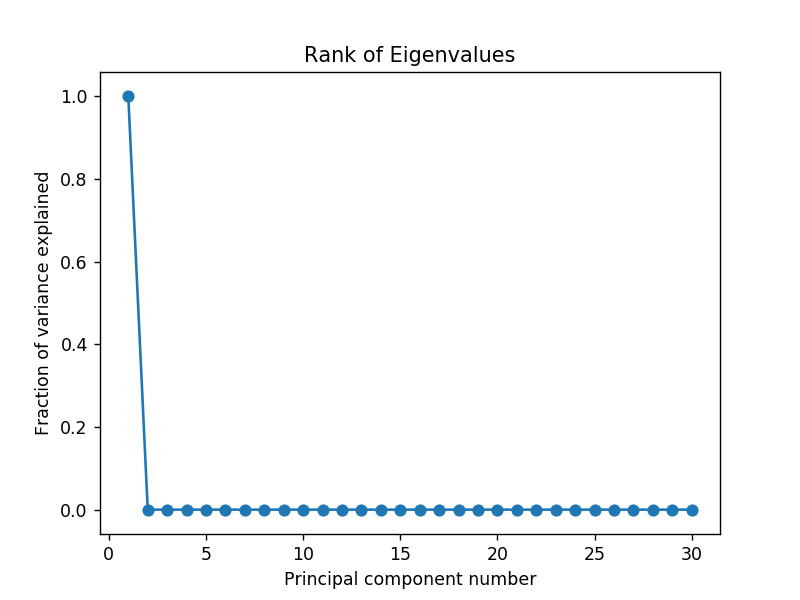

Text(0.5, 1.0, 'Rank of Eigenvalues')

In [61]:
plt.figure()
plt.scatter(eigval_dict.keys(),eigval_dict.values())
plt.plot(list(eigval_dict.keys()),list(eigval_dict.values()))
plt.xlabel('Principal component number')
plt.ylabel('Fraction of variance explained')
plt.title('Rank of Eigenvalues')

<IPython.core.display.Javascript object>


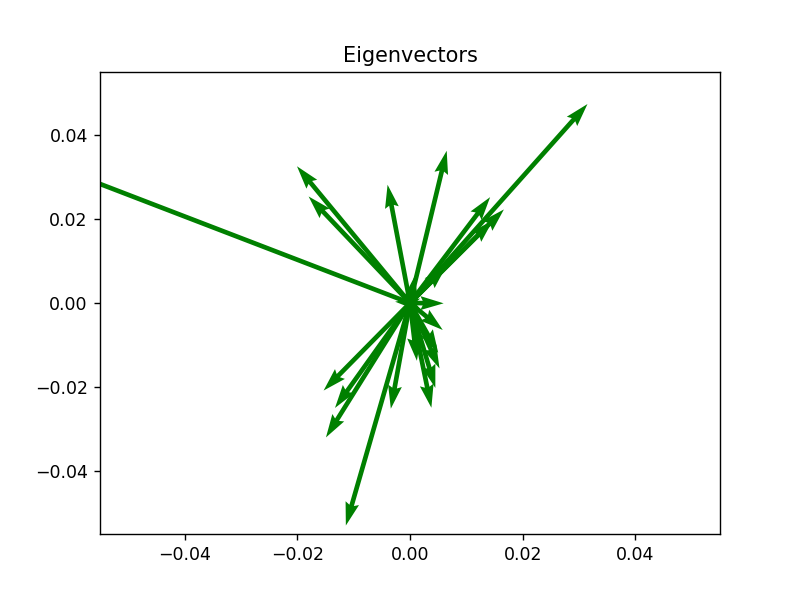

In [76]:
plt.figure()
plt.title('Eigenvectors')
for i in np.arange(eigvec.shape[0]):
    plt.quiver([0,0],*eigvec[:,i],scale=1.15,color='g')
plt.show()

## Feature Vector and Final Data

Based on the explained variance, you can leave out components that are less signficant which results in the final data having less dimensions than the original. We put the eigenvectors of importance in the <b>feature vector</b>.

After forming the feature vector, we can determine the final data set which will reorient the data to be represented by the principal components instead of the original axes. You multiply the tranpose of the feature vector with the tranpose of the standardized data matrix (or B matrix).
$$FinalData = FeatureVector^{T} * B^{T}$$

In [70]:
feature_vec = np.array(eig_pairs[0][1]).reshape(cov.shape[0],1) #feature vector
# print(feature_vec)
final_data = np.dot(feature_vec.T,stand_matrix.T) #multiplying transpose of feature vector and transpose of normalized matrix
print(final_data.shape)

(1, 500)
